In [1]:
import torch

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

#生成等边三角形
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

#每条边中点位置
midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 for i in range(3)]

def xy2bc(xy, tol=1.e-3):
    #将三角形顶点的笛卡尔坐标映射到重心坐标系
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

#有了重心坐标，可以计算Dirichlet概率密度函数的值
class Dirichlet(object):

    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        from functools import reduce
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / reduce(mul, [gamma(a) for a in self._alpha]) #reduce:sequence连续使用function

    def pdf(self, x):
        #返回概率密度函数值
        from operator import mul
        from functools import reduce
        return self._coef * reduce(mul, [xx ** (aa - 1) for (xx, aa)in zip(x, self._alpha)])

def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    #细分等边三角形网格
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

In [81]:
ex = torch.from_numpy(np.array([-1.4359, 0.1868,  1.0484]))

In [82]:
torch.sigmoid(ex)

tensor([0.1922, 0.5466, 0.7405], dtype=torch.float64)

In [87]:
torch.softmax(ex, dim=0)*99 + 1

tensor([ 6.4819, 28.7754, 66.7428], dtype=torch.float64)

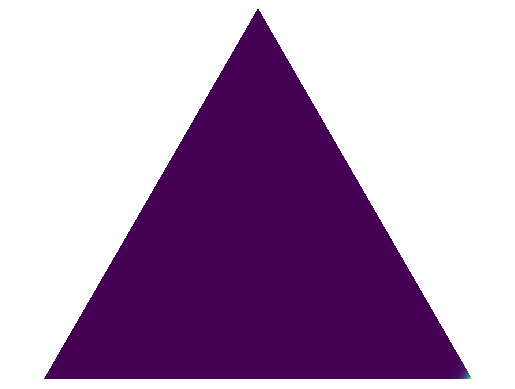

In [64]:
draw_pdf_contours(Dirichlet([1, 100, 1]))

In [3]:
# 制作数据集
import sys
import os
root = "/data/public/renhaoye/morphics/"
subdirs = [os.path.join(root, d) for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
for subdir in subdirs:
    sys.path.append(subdir)
from dataset.galaxy_dataset import *
from utils import schemas
from utils.utils import *
from models.utils import *
import random
from torch.backends import cudnn
def init_rand_seed(rand_seed):
    torch.manual_seed(rand_seed)
    torch.cuda.manual_seed(rand_seed)  # 为当前GPU设置随机种子
    torch.cuda.manual_seed_all(rand_seed)  # 为所有GPU设置随机种子
    np.random.seed(rand_seed)
    random.seed(rand_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
init_rand_seed(1926)
question_answer_pairs = gz2_pairs
dependencies = gz2_and_decals_dependencies
schema = schemas.Schema(question_answer_pairs, dependencies)

In [4]:
img = torch.Tensor(load_img("/data/public/renhaoye/morphics/dataset/in_decals/agmtn/119.85429851358965_28.803799075693085.fits"))
model = torch.load("/data/public/renhaoye/morphics/pth/model_65.pt", map_location="cuda:0")
img.shape

torch.Size([3, 256, 256])

In [20]:
predict, stn= model(img.unsqueeze(0).to("cuda:0"))
# fits.writeto(f'/data/public/renhaoye/pth.fits', stn[0].cpu().detach().numpy(), overwrite=True)
predict

tensor([[-0.3994,  1.3372, -1.8798, -1.9430,  2.1300,  1.3059, -1.3460, -2.0077,
          0.3053,  1.6144, -5.7010, -2.6987,  0.5484,  2.0159, -1.4663,  0.6666,
          0.9039, -2.6334, -1.3481,  0.0376,  0.5895,  1.0647, -0.0344, -1.4396,
         -2.3682,  0.4567,  0.3034, -0.7039, -0.9740,  0.8007,  1.4854,  0.3862,
         -1.0090, -1.5029]], device='cuda:0', grad_fn=<AddBackward0>)

In [11]:
predict = softmax_output(predict,schema.question_index_groups)
predict

tensor([[ 21.3821,  79.6179,   0.0000, 100.0000,   0.0000, 100.0000,   0.0000,
          10.3456,  90.6544,   0.0000,   1.0818,   2.2423,  25.7322,  73.9438,
           0.0000,  13.4289,  87.5711,   0.0000,  17.0320,  83.9680,   0.0000,
          70.6282,  30.3718,   0.0000,   4.8940,  49.2053,  32.7035,  11.8324,
           5.3648,   0.0000,  59.3840,  31.1927,  11.4234,   0.0000]],
       device='cuda:0', grad_fn=<CopySlices>)

In [7]:
output_ = []
for mc_run in range(100):
    output, _ = model(img.unsqueeze(0).to("cuda:0"))
    output_.append(softmax_output(output,schema.question_index_groups))
predict = torch.mean(torch.stack(output_), dim=0)

In [8]:
predict

tensor([[1.8373e-01, 8.1627e-01, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 9.4517e-02, 9.0548e-01, 0.0000e+00, 3.9221e-04, 8.5420e-03,
         2.6249e-01, 7.2858e-01, 0.0000e+00, 4.3372e-01, 5.6628e-01, 0.0000e+00,
         2.4300e-01, 7.5700e-01, 0.0000e+00, 7.3903e-01, 2.6097e-01, 0.0000e+00,
         2.2968e-02, 3.4617e-01, 3.8609e-01, 1.7332e-01, 7.1457e-02, 0.0000e+00,
         7.2108e-01, 2.3048e-01, 4.8438e-02, 0.0000e+00]], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [5]:
# 将img的batchsize变成100以重复100次预测
img = img.unsqueeze(0).repeat(100,1,1,1).to("cuda:0")
predict, _ = model(img)
# output_.append(softmax_output(output,schema.question_index_groups))
# predict = torch.mean(torch.stack(output_), dim=0)

In [8]:
predict = softmax_output(predict,schema.question_index_groups)
predict = torch.mean(predict, dim=0)

In [9]:
predict

tensor([1.8776e-01, 8.1224e-01, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 9.6046e-02, 9.0395e-01, 0.0000e+00, 4.0164e-04, 8.7288e-03,
        2.7191e-01, 7.1896e-01, 0.0000e+00, 4.1080e-01, 5.8920e-01, 0.0000e+00,
        2.4650e-01, 7.5350e-01, 0.0000e+00, 7.3532e-01, 2.6468e-01, 0.0000e+00,
        2.3337e-02, 3.5907e-01, 3.9032e-01, 1.6347e-01, 6.3808e-02, 0.0000e+00,
        7.2410e-01, 2.2828e-01, 4.7621e-02, 0.0000e+00], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [10]:
target_layer = list(list(model.children())[0].children())[-2]
target_layer

AdaptiveAvgPool2d(output_size=1)